# The useful code again

In [134]:
'''
This code generates a dataset of biased random walks that is stored in Pandas DataFrames.
'''

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd


# Constants
START_TIME = 0.0 #do not modify
END_TIME = 20.0 #duration of tracking 'experiment'
TIME_INCREMENT = 0.1 #time step size
STEP_NUMBER = int(END_TIME/TIME_INCREMENT) #do not modify

WORLD_SIZE_X = 10.0 #world width 
WORLD_SIZE_Y = 10.0 #world height

START_POSITION_RANDOM = True #toggle whether start position is random
START_POSITION = (5.0, 5.0) #start position if not random (set to centre of world, may be modified)

TOTAL_SPEED = 1.2 #assumed to be constant property of bacterium in given environment

TUMBLE_THRESHOLD = 0.6 #threshold used by reorientation function; higher threshold makes reorientation less likely

REPEAT_NUMBER = 1000 #number of tracks to be obtained


# Helper functions
def test_out_of_bounds(x, y, velocity_x, velocity_y):
    '''
    Test whether the cell has reached the walls of the world and reset velocity components to make cell bounce off 
    wall if appropriate. Collisions are assumed to be perfectly elastic with the wall infinitely heavy.
    '''
    if x >= WORLD_SIZE_X or x <= 0:
        velocity_x = -velocity_x
    if y >= WORLD_SIZE_Y or y <= 0:
        velocity_y = -velocity_y
    return (velocity_x, velocity_y)

def attractant_distribution(x, y):
    '''
    Describes the distribution of an attractant. This can be modified by the user.
    Note the function should not have zero values within the range of coordinates included in the world.
    '''
    #attractant_concentration = 0.15*x**2 - 0.15*y**2 + 0.1
    attractant_concentration = 1 + 5*x
    return attractant_concentration

def set_speed():
    '''
    Sets x- and y-components of the velocity to random values.
    The vector magnitude (TOTAL_SPEED) is kept constant.
    '''
    velocity_x = random.uniform(-TOTAL_SPEED, TOTAL_SPEED) #randomise x-component of velocity
    velocity_y = (TOTAL_SPEED**2 - velocity_x**2) #use formula for vector magnitude
    random_orientation_y = random.uniform(-1,1) #magnitude of velocity_y is fixed when velocity_x is fixed, but not sign
    if random_orientation_y >= 0.0: #use random number to determine sign of y-component
        velocity_y = -velocity_y
    return (velocity_x, velocity_y)

def set_start_position():
    '''
    Generate a random start position for each track
    '''
    x = random.uniform(0.0,10.0)
    y = random.uniform(0.0,10.0)
    return (x,y)

def update_position(x, y, velocity_x, velocity_y):
    '''
    Update the position of the cell with each time step.
    '''
    x = x + velocity_x * TIME_INCREMENT
    y = y + velocity_y * TIME_INCREMENT
    return (x, y)

def reorientation(time, time_last_tumble, x, y):
    '''
    Determines whether the cell should reorient at a given time (returns a Boolean).
    Reorientation probability depends on the time since last tumble and the attractant concentration.
    A random component is added using a random number generator (motor switching is partly stochastic).
    '''
    attractant_concentration = attractant_distribution(x, y)
    
    time_since_last_tumble = time - time_last_tumble
    random_number = random.uniform(0.0,5.0)
    time_dependent_random_number = time_since_last_tumble * random_number
    
    return (time_dependent_random_number / attractant_concentration) > TUMBLE_THRESHOLD

def get_track():
    '''
    Generates a random track using the specified constants. 
    A random start position may be chosen, or this may be specified as a constant
    '''
    cell_location_x = np.zeros(STEP_NUMBER) #set up empty array to store track x-coordinates
    cell_location_y = np.zeros(STEP_NUMBER) #set up empty array to store track y-coordinates
    run_length = [] #set up empty list in which to store run lengths (in units of time)
    
    time = START_TIME
    time_last_tumble = START_TIME
    (velocity_x, velocity_y) = set_speed()
    
    if START_POSITION_RANDOM:
        start_position = set_start_position()
        (x,y) = start_position
    else:
        (x,y) = START_POSITION
        
    (cell_location_x[0], cell_location_y[0]) = (x,y) #new line
    
    for i in range(STEP_NUMBER-1): #note altered range
        (velocity_x, velocity_y) = test_out_of_bounds(x,y, velocity_x, velocity_y)
        (x, y) = update_position(x, y, velocity_x, velocity_y)
        cell_location_x[i+1] = x #note offset in counter
        cell_location_y[i+1] = y #note offset in counter
        time = time + TIME_INCREMENT
        if reorientation(time, time_last_tumble, x, y):
            (velocity_x, velocity_y) = set_speed()
            run_length.append(time-time_last_tumble)
            time_last_tumble = time
    end_position = (x,y)
            
    return cell_location_x, cell_location_y, run_length, start_position, end_position


#main function (obtain database for multiple tracks)
'''
Generates and stores a number (REPEAT_NUMBER) of random tracks produced by get_track().
Results are stored in lists. Associated track numbers are stored in separate lists.
'''
run_length_database = [] #create empty lists that will become dataframe columns
run_length_track_numbers_database = []
x_coordinate_database = []
y_coordinate_database = []
coordinate_track_numbers_database = []
x_displacement_database = []
y_displacement_database = []
displacement_track_numbers_database = []

for i in range(REPEAT_NUMBER):
    (cell_location_x, cell_location_y, run_length, start_position, end_position) = get_track()
    
    run_length_database.extend(run_length) #add new values to future columns
    x_coordinate_database.extend(cell_location_x)
    y_coordinate_database.extend(cell_location_y)
    x_displacement_database.append(end_position[0]-start_position[0])
    y_displacement_database.append(end_position[1]-start_position[1])
    
    run_length_track_number = [i]*len(run_length) #generate lists of track numbers to associate with values in columns
    run_length_track_numbers_database.extend(run_length_track_number)
    coordinate_track_number = [i]*len(cell_location_x)
    coordinate_track_numbers_database.extend(coordinate_track_number)
    displacement_track_numbers_database.append(i)

    
#dataframe creation
'''
Stores the track coordinates and relevant parameters in Pandas dataframes.
'''
df_coordinates = pd.DataFrame([coordinate_track_numbers_database, x_coordinate_database, y_coordinate_database])
df_coordinates = df_coordinates.transpose()
df_coordinates.columns = ['track_number_coordinate','x_coordinate', 'y_coordinate']

df_run_lengths = pd.DataFrame([run_length_track_numbers_database, run_length_database])
df_run_lengths = df_run_lengths.transpose()
df_run_lengths.columns = ['track_number_run', 'run_length']

df_displacements = pd.DataFrame([displacement_track_numbers_database, x_displacement_database, y_displacement_database])
df_displacements = df_displacements.transpose()
df_displacements.columns = ['track_number_displacement', 'x_displacement', 'y_displacement']

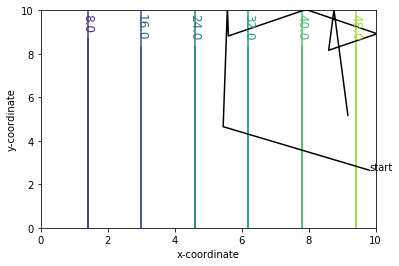

In [135]:
#plotting the output of get_track()
'''
Plots a random track using arrays of coordinates returned by get_track().
Labels the track start point.
Plots the attractant distribution as a contour plot. 
(Warning: the contour plotting will produce an error for a constant attractant concentration,)
'''
plt.plot(cell_location_x.T, cell_location_y.T, 'k') #take transpose of arrays to associate coordinates appropriately
axes = plt.gca()
axes.set_xlim([0.0,10.0])
axes.set_ylim([0.0,10.0])
axes.set_xlabel('x-coordinate')
axes.set_ylabel('y-coordinate')

plt.annotate('start', start_position) #annotate the track start position

xa, ya = np.meshgrid(np.arange(0.0,10.0,0.05), np.arange(0.0,10.0,0.05))
plt.contour(xa, ya, attractant_distribution(xa, ya)) 
CS = axes.contour(xa, ya, attractant_distribution(xa,ya))
axes.clabel(CS, inline=1, fontsize=12, fmt='%1.1f')

#plt.savefig('track.pdf')
plt.show()

In [136]:
df_total = pd.concat([df_coordinates, df_displacements, df_run_lengths], axis=1)
df_total

,track_number_coordinate,x_coordinate,y_coordinate,track_number_displacement,x_displacement,y_displacement,track_number_run,run_length
0,0.0,1.493380,6.577048,0.0,3.505193,-4.176193,0.0,6.5
1,0.0,1.608453,6.565465,1.0,1.702651,3.934682,0.0,3.3
2,0.0,1.723525,6.553881,2.0,-5.494803,-1.585809,0.0,5.7
3,0.0,1.838598,6.542298,3.0,7.750306,0.090319,0.0,3.9
4,0.0,1.953670,6.530715,4.0,-0.141671,0.311193,1.0,3.7
...,...,...,...,...,...,...,...,...
199995,999.0,9.122651,5.742093,NaN,NaN,NaN,NaN,NaN
199996,999.0,9.134870,5.599586,NaN,NaN,NaN,NaN,NaN
199997,999.0,9.147089,5.457079,NaN,NaN,NaN,NaN,NaN
199998,999.0,9.159308,5.314572,NaN,NaN,NaN,NaN,NaN


# The exercises
1. Derive the ```df_displacement``` values from the ```df_coordinates``` values.
2. Visit the visualisation section of the Pandas documentation (https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html). Using the provided dataset, generate one of the plot types not showcased in the notebook. If you like, you can modify the constants or the attractant concentration function to change the cell's behaviour in any way you find interesting to create your own dataset.
3. Return to the statistics notebook, and compare two different columns in a quantitative way. 
4. Load one of your own tabular datasets into a Pandas DataFrame, and make an interesting plot!

1. Creation of a new column in df_coordinates

In [137]:
#we can add a column of a different length by creating a new dataframe and concatenating
df_numbers = pd.DataFrame(np.arange(100))
df_numbers.columns = ['track_number_displacement']
df_coordinatesnew = pd.concat([df_coordinates, df_numbers], axis =1)

#we can add a new empty column and then populate it with values as well, but that's not necessary here
#df_coordinatesnew['x_displacement'] = np.NaN
#df_coordinatesnew['y_displacement'] = np.NaN

for i in range(REPEAT_NUMBER):
    value = (df_coordinatesnew.at[(199+i*200),'x_coordinate'] - df_coordinatesnew.at[i*200, 'x_coordinate'])
    df_coordinatesnew.at[i, 'x_displacement'] = value
    valuey = (df_coordinatesnew.at[(199+i*200),'y_coordinate'] - df_coordinatesnew.at[i*200, 'y_coordinate'])
    df_coordinatesnew.at[i, 'y_displacement'] = valuey

#let's look at the result
df_coordinatesnew


,track_number_coordinate,x_coordinate,y_coordinate,track_number_displacement,x_displacement,y_displacement
0,0.0,1.493380,6.577048,0.0,3.505193,-4.176193
1,0.0,1.608453,6.565465,1.0,1.702651,3.934682
2,0.0,1.723525,6.553881,2.0,-5.494803,-1.585809
3,0.0,1.838598,6.542298,3.0,7.750306,0.090319
4,0.0,1.953670,6.530715,4.0,-0.141671,0.311193
...,...,...,...,...,...,...
199995,999.0,9.122651,5.742093,NaN,NaN,NaN
199996,999.0,9.134870,5.599586,NaN,NaN,NaN
199997,999.0,9.147089,5.457079,NaN,NaN,NaN
199998,999.0,9.159308,5.314572,NaN,NaN,NaN


We can compare it with the displacements dataframe:

In [138]:
df_displacements.head()

,track_number_displacement,x_displacement,y_displacement
0,0.0,3.505193,-4.176193
1,1.0,1.702651,3.934682
2,2.0,-5.494803,-1.585809
3,3.0,7.750306,0.090319
4,4.0,-0.141671,0.311193


If the code to create ```dfcoordinatesnew``` is run with the original version of the model, the values appear to be slightly off! This occurs because the start position was not being saved into the array of coordinates, but it was being used to calculate the net displacement. I've altered the model code to remove this discrepancy.

2. Seaborn violin plot

If you have a Pandas DataFrame, you can actually go beyond the Pandas data visualisation methods and use another library called Seaborn (https://seaborn.pydata.org/). This is similarly based on matplotlib and can handle DataFrame objects, but has a lot of good options for plotting 'statistical graphics'.

Text(0.5, 1.0, 'Comparison of x-displacement at different attractant concentrations')

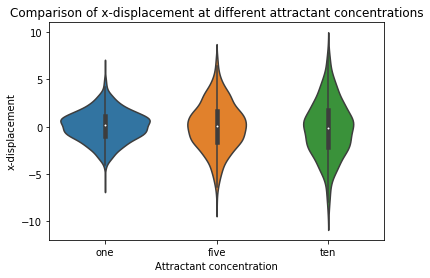

In [154]:
import seaborn as sns

df_one = pd.read_csv('attractantisone.csv')
df_five = pd.read_csv('attractantisfive.csv')
df_ten = pd.read_csv('attractantisten.csv')

df_concat = pd.concat([df_one['x_displacement'], df_five['x_displacement'], df_ten['x_displacement']], axis=1)
df_concat.columns = ['one', 'five', 'ten']
df_concat = df_concat.dropna()

sns.violinplot(data=df_concat)
axes = plt.gca()
axes.set_xlabel('Attractant concentration')
axes.set_ylabel('x-displacement')
axes.set_title('Comparison of x-displacement at different attractant concentrations')

3. Dataset of two attractant concentrations

The SciPy stats functions (https://docs.scipy.org/doc/scipy/reference/stats.html) work with DataFrame columns. Note some of these functions (that don't have a nan_policy argument) might have issues if NaN values were still present.

In [161]:
import scipy as sp

We can first see whether our distribution is normal (this is a Shapiro-Wilk test, the second value returned is a p-value that we can use to determine whether the null hypothesis that the null hypothesis (sample drawn from a normal distribution) should be rejected):

In [160]:
sp.stats.shapiro(df_concat['one'])

(0.9984759092330933, 0.5389897227287292)

It seems that we might get away with using a test that assumes normality.

In [163]:
sp.stats.ttest_ind(df_concat['one'], df_concat['ten'], equal_var = True, nan_policy = 'omit') 
#note we actually already removed NaNs

Ttest_indResult(statistic=2.534247363585437, pvalue=0.011344710707071451)

In [159]:
sp.stats.f_oneway(df_concat['one'], df_concat['five'], df_concat['ten'])

F_onewayResult(statistic=3.6881902582014323, pvalue=0.02513085502383884)

Other tests are equally possible:

In [158]:
sp.stats.mannwhitneyu(df_concat['one'], df_concat['ten'])

MannwhitneyuResult(statistic=465868.0, pvalue=0.00410688437993527)